In [3]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot_ng as pydot

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [81]:
df = pd.read_csv('data/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [82]:
# number of images in train set
n = len(df)
# all names of dog breeds
breed = set(df['breed'])
# number of dog breeds
n_class = len(breed)

class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [7]:
# Images need to be resized to a same size for trainning
# The width of image after resizing, 299 is the default input size for the models.
width = 299

# to store images after cv2 transfer
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)

# tqdm is used to display the process
for i in tqdm(range(n)):
    # '%'
    X[i] = cv2.resize(cv2.imread('data/train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:32<00:00, 314.74it/s]


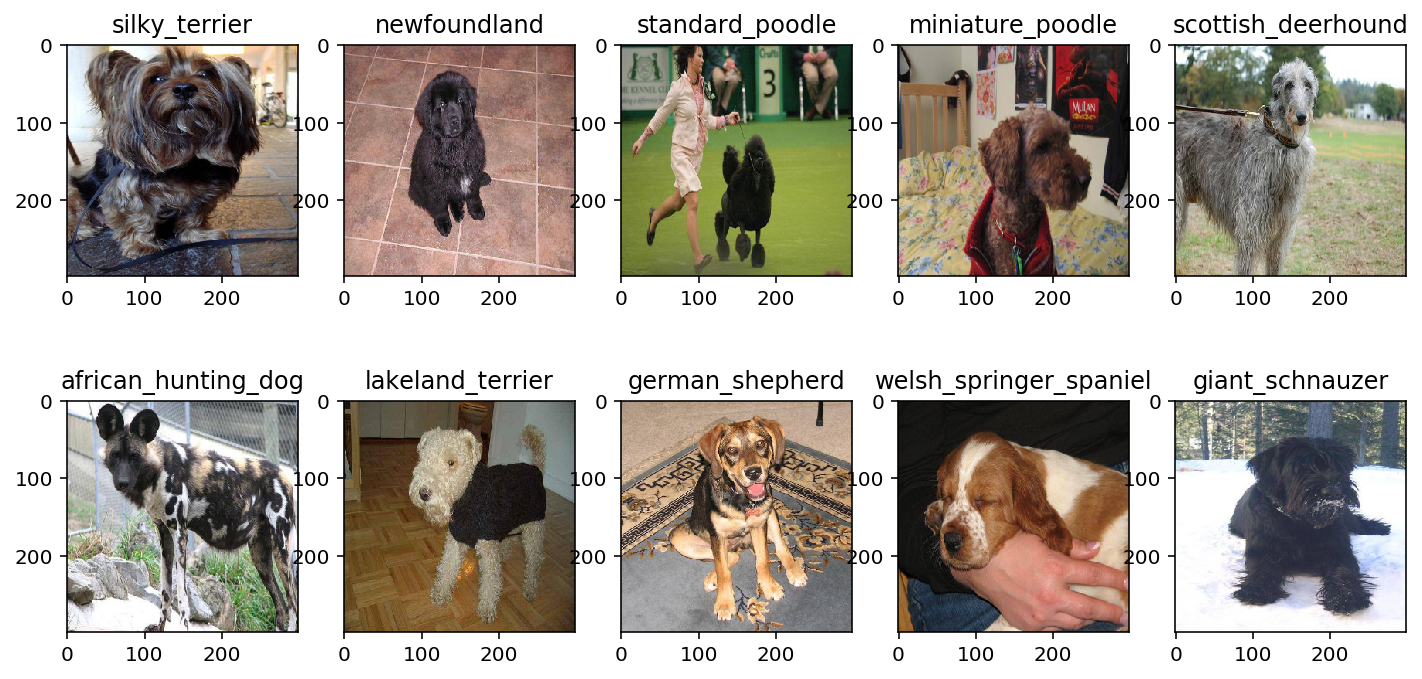

In [8]:
plt.figure(figsize=(12, 6))
for i in range(10):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 5, i+1)
    # BGR to RGB
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

In [67]:
def get_features(MODEL, data):
    # weights='imagenet'
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    # preprocess_input to modify input format for the model
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [10]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

160/160 [==============================] - 1022s 6s/step


In [25]:
X.shape

(10222, 299, 299, 3)

In [11]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
72/72 [==============================] - 1s 14ms/step - loss: 2.0114 - accuracy: 0.5913 - val_loss: 0.7537 - val_accuracy: 0.8133
Epoch 2/10
72/72 [==============================] - 1s 16ms/step - loss: 0.6101 - accuracy: 0.8387 - val_loss: 0.5797 - val_accuracy: 0.8397
Epoch 3/10
72/72 [==============================] - 1s 14ms/step - loss: 0.4419 - accuracy: 0.8767 - val_loss: 0.5130 - val_accuracy: 0.8397
Epoch 4/10
72/72 [==============================] - 1s 14ms/step - loss: 0.3616 - accuracy: 0.8971 - val_loss: 0.4949 - val_accuracy: 0.8495
Epoch 5/10
72/72 [==============================] - 1s 13ms/step - loss: 0.3069 - accuracy: 0.9117 - val_loss: 0.4841 - val_accuracy: 0.8573
Epoch 6/10
72/72 [==============================] - 1s 12ms/step - loss: 0.2629 - accuracy: 0.9281 - val_loss: 0.4531 - val_accuracy: 0.8583
Epoch 7/10
72/72 [==============================] - 1s 12ms/step - loss: 0.2273 - accuracy: 0.9415 - val_loss: 0.4523 - val_accuracy: 0.8524
Epoch 8/10
72

In [70]:
model.save('model/')

INFO:tensorflow:Assets written to: model/assets


In [73]:
reconstructed_model = load_model("model")

In [14]:
# Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Text(0.5, 0, 'epoch')

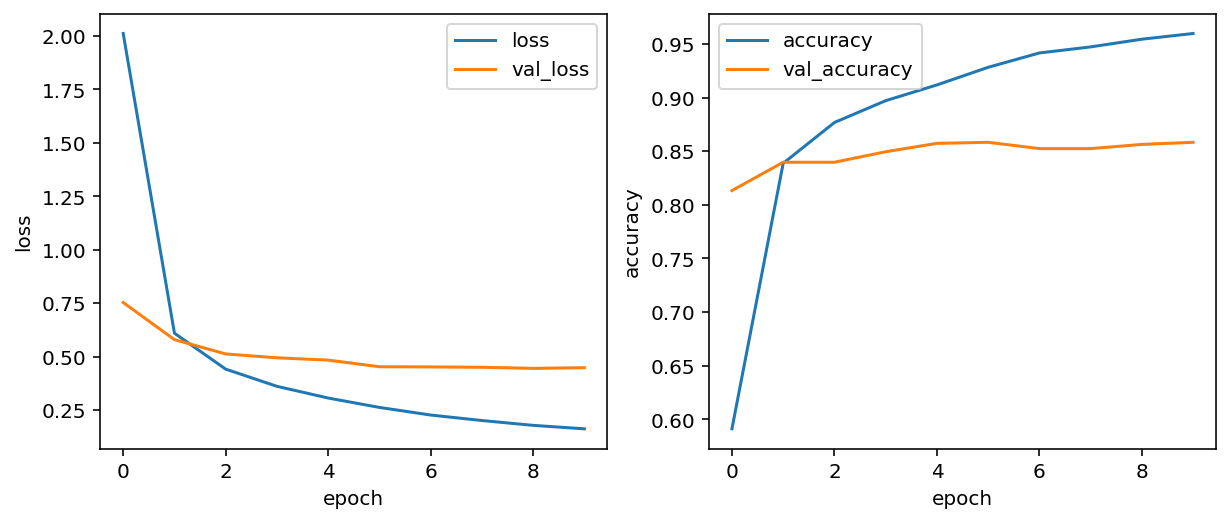

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [15]:
df2 = pd.read_csv('data/sample_submission.csv')
df2.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [17]:
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('data/test/%s.jpg' % df2['id'][i]), (width, width))

100%|██████████| 10357/10357 [00:29<00:00, 353.48it/s]


In [18]:
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis=-1)

162/162 [==============================] - 1122s 7s/step


In [77]:
y_pred = model.predict(features_test, batch_size=128)

In [20]:
for b in breed:
    df2[b] = y_pred[:,class_to_num[b]]

In [21]:
df2.to_csv('pred.csv', index=None)

In [ ]:
X_predict = np.zeros((1, width, width, 3), dtype=np.uint8)
X_predict[0] = cv2.resize(cv2.imread('data/test/00102ee9d8eb90812350685311fe5890.jpg'), (width, width))
plt.imshow(X_predict[0][:,:,::-1])

inception_features_predict = get_features(InceptionV3, X_predict)
xception_features_predict = get_features(Xception, X_predict)
features_predict = np.concatenate([inception_features_predict, xception_features_predict], axis=-1)

y_predict = model.predict(features_predict, batch_size=128) 
result_prob = np.max(y_predict[0])
result = np.argmax(y_predict[0])

print(num_to_class[result])